Cascade Generator
====

In [1]:
import numpy as np
import qftlib as qft
import simplemc
from field_reduction import spectrum
from IPython.display import display
import time

In [2]:
SEED = 1234 # this is the global seed, it is used to produces all local seeds
INIT_ELEC_ENERGY_SCALE = 50 # => 50*m_e ~ 2.5 MeV


def run_cascade_generator(max_no_events=None,init_verbose=None,run_verbose=None,method=0,sigma=0.7,epsilon=0.01):
    if max_no_events is None:
        max_no_events = simplemc.DEFAULTS.max_no_events
        print(f"Warning: the default number of events are used: max_no_events = {simplemc.DEFAULTS.max_no_events}")
        
    init_verbose = bool(init_verbose)
    run_verbose = bool(run_verbose)
    
    seed_gen = simplemc.seed_generator(seed = SEED)
    init_seed = next(seed_gen)
    init_mom = simplemc.generate_rnd_momentum(seed = init_seed,mass = 1,scale=INIT_ELEC_ENERGY_SCALE)
    init_electron = simplemc.ParticleRecord(init_mom,charge=1)
    
    field_omega = 0.01 # => 0.01*m_e ~ 5.11 keV
    field_ref_mom = qft.FourMomentum(np.array([field_omega,0,0,field_omega]),mass = 0)
    field_reduction_method = method               # 0 = full scaling, 1 = hole burning (dirac series), 2 = hole burning (delta)
    field_sigma = sigma                           # sigma_l = 1/sigma_phi
    field_mu = 1.0                                # centering of the normal distribution (=1 from derivation)
    field_A = 3.3 * (2*np.pi)**0.5 / field_sigma  # amplitude of the normal distribution
    dirac_epsilon = epsilon                       # width parameter of dirac series
    field_spec = spectrum(A=field_A,mu=field_mu,sigma=field_sigma,method=field_reduction_method,omega=field_ref_mom.E, epsilon=dirac_epsilon)

    init_field_rec = simplemc.FieldRecord(field_ref_mom,field_spec,spectrum_bounds=(-3,3))

    
    
    init_record = simplemc.EventRecord(init_electron,init_field_rec)
    
    
    
    Generator = simplemc.EventGenerator(init_record,max_no_events=max_no_events)
    event_record_list = simplemc.EventRecordList()
    
    if init_verbose:
        print("Initialisation")
        print("="*10,"init_seed","="*10)
        print(init_seed)
        print()
        print()
        print("="*10,"init event record","="*10)
        print()
        print(Generator.current_event)
        
    event_number = 0
    start_time = time.time()
    dh = display('Starting generator',display_id=True)
    for _ in Generator:
        dh.update(f"Generating event {event_number}")
        if run_verbose:
            print("="*10,f"Event {event_number}","="*10)
            print(Generator.current_event)
        event_record_list.add_records(Generator.current_event)
        event_number+=1
    end_time = time.time()
    print(f'Last event: {event_number-1}')
    # The first generated event will be event number 0, because it includes the initial initial incoming and the first generated
    # outgoing field. Because 1 is added after generation the number of the last event has to be decreased by 1.
    print(f'Runtime = {round((end_time - start_time), 3)} s')
        
    return event_record_list

In [3]:
print('Full scaling')
res0 = run_cascade_generator(max_no_events=1000,method=0)

Full scaling


'Starting generator'

Stopping because E < 0
Last event: 947
Runtime = 5.915 s


In [4]:
print('Dirac Series')
res1 = run_cascade_generator(max_no_events=1000,method=1)

Dirac Series


'Starting generator'

Found roots: [1.8624999999994647, 1.9124999999994587], stopping generator
Last event: 68
Runtime = 2.522 s


In [5]:
print('Delta Distriubtions')
res2 = run_cascade_generator(max_no_events=1000,method=2)

Delta Distriubtions


'Starting generator'

Stopping because E < 0
Last event: 947
Runtime = 23.289 s


In [6]:
# Print all generations
#print(res1)

In [7]:
# Print first gen with l!=0
#print(res0.records[9])

In [8]:
# Print last gen
#print(res1.records[-1])

In [9]:
def get_electron_energy(event_rec_list):
    N = len(event_rec_list)
    energies = np.empty(N,dtype=float)
    for i,rec in enumerate(event_rec_list.records):
        electron_record = rec.outgoing_particles.records[0]
        assert electron_record.charge == 1
        assert electron_record.mass == 1
        energies[i] = electron_record.mom.E[0]
    return energies

In [10]:
get_electron_energy(res0)

array([45.17274452, 45.17274452, 45.17274452, 45.17274452, 45.17274452,
       45.17274452, 45.17274452, 45.17274452, 45.17274452, 12.47008904,
       12.47008904, 12.47008904, 12.47008904, 12.47008904, 12.47008904,
       12.47008904, 12.47008904,  4.66581635,  4.66581635,  4.66581635,
        4.66581635,  4.66581635,  4.66581635,  4.66581635,  4.66581635,
        4.66581635,  4.66581635,  4.66581635,  1.27792245,  1.27792245,
        1.27792245,  1.01238678,  1.01238678,  1.01238678,  1.01238678,
        1.00320511,  1.00320511,  1.00320511,  1.00320511,  1.00320511,
        1.00114985,  1.0000569 ,  1.0000569 ,  1.0000569 ,  1.00001357,
        1.00001357,  1.00001357,  1.00001357,  1.00001357,  1.00001357,
        1.00001357,  1.00000048,  1.00000048,  1.00000048,  1.00000048,
        1.00000048,  1.00000048,  1.00000048,  1.00000048,  1.00000048,
        1.00000048,  1.00000048,  1.00000048,  1.00000048,  1.00000048,
        1.00000016,  1.00000016,  1.00000016,  1.        ,  1.  

In [11]:
def get_en_frac_sum(event_rec_list):
    N = len(event_rec_list)
    en_fracs = np.empty(N,dtype=float)
    for i,rec in enumerate(event_rec_list.records):
        en_fracs[i] = np.sum(rec.en_fracs)
    return en_fracs

def get_en_frac_cumsum(event_rec_list):
    return np.cumsum(get_en_frac_sum(event_rec_list))

In [12]:
get_en_frac_sum(res0)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09244902,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17752897, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.69759598, 0.        ,
       0.        , 1.91940495, 0.        , 0.        , 0.        ,
       1.75926523, 0.        , 0.        , 0.        , 0.        ,
       1.78162925, 1.46976897, 0.        , 0.        , 1.43374117,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.79228586, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.74976756, 0.        , 0.        , 1.94412402, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [13]:
get_en_frac_cumsum(res0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.24490206e-02, 9.24490206e-02, 9.24490206e-02,
       9.24490206e-02, 9.24490206e-02, 9.24490206e-02, 9.24490206e-02,
       9.24490206e-02, 2.69977986e-01, 2.69977986e-01, 2.69977986e-01,
       2.69977986e-01, 2.69977986e-01, 2.69977986e-01, 2.69977986e-01,
       2.69977986e-01, 2.69977986e-01, 2.69977986e-01, 2.69977986e-01,
       9.67573964e-01, 9.67573964e-01, 9.67573964e-01, 2.88697892e+00,
       2.88697892e+00, 2.88697892e+00, 2.88697892e+00, 4.64624414e+00,
       4.64624414e+00, 4.64624414e+00, 4.64624414e+00, 4.64624414e+00,
       6.42787340e+00, 7.89764237e+00, 7.89764237e+00, 7.89764237e+00,
       9.33138355e+00, 9.33138355e+00, 9.33138355e+00, 9.33138355e+00,
       9.33138355e+00, 9.33138355e+00, 9.33138355e+00, 1.11236694e+01,
       1.11236694e+01, 1.11236694e+01, 1.11236694e+01, 1.11236694e+01,
      

In [14]:
elec_en = [get_electron_energy(res0),get_electron_energy(res1),get_electron_energy(res2)]
en_fracs = [get_en_frac_cumsum(res0),get_en_frac_cumsum(res1),get_en_frac_cumsum(res2)]

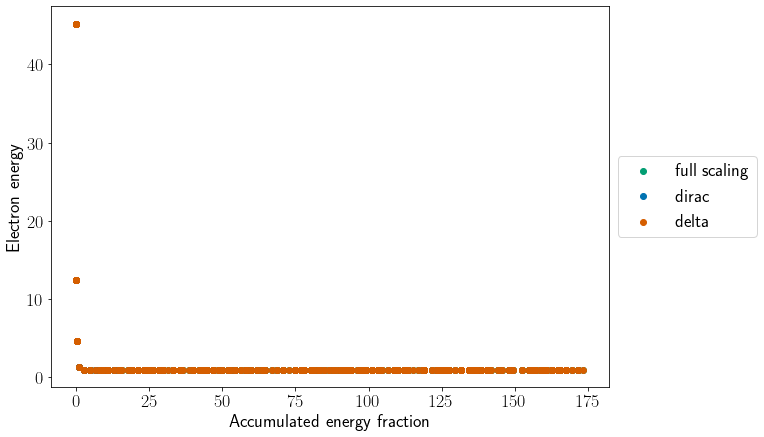

In [15]:
import matplotlib.pylab as plt
from matplotlib import rc
import seaborn

rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
seaborn.set_color_codes("colorblind")

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(en_fracs[0],elec_en[0],c="g", label="full scaling")
ax.scatter(en_fracs[1],elec_en[1],c="b", label="dirac")
ax.scatter(en_fracs[2],elec_en[2],c="r", label="delta")
ax.set_ylabel("Electron energy")
ax.set_xlabel("Accumulated energy fraction")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

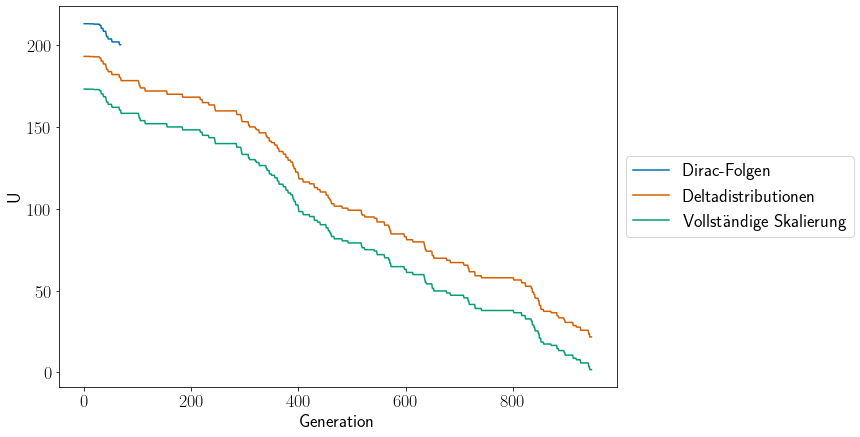

In [16]:
# Plot E_tot (excluding last event)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

def count_stuff(records):
    x_i = []  # Generation
    y_i = []  # E_tot
    z_i = []  # Particle count (incoming)
    for n, rec in enumerate(records):
        # Excludes the last generated particle(s) that reduced the field below 0 since they were 'illegal'.
        # If this already happens at the first particle, then the graph will be a constant 1 (and the energy stays at starting value).
        x_i.append(n)
        y_i.append(rec.in_field.total_energy)
        z_i.append(len(rec.incoming_particles))
    return[x_i,y_i,z_i]
values0 = count_stuff(res0.records)
values1 = count_stuff(res1.records)
values2 = count_stuff(res2.records)

for i in range(len(values1[1])):
    values1[1][i] = values1[1][i] +40#*1.5
for i in range(len(values2[1])):
    values2[1][i] = values2[1][i] +20#*1.25

ax.plot(values1[0], values1[1], c="b", label="Dirac-Folgen")
ax.plot(values2[0], values2[1], c="r", label="Deltadistributionen")
ax.plot(values0[0], values0[1], c="g", label="Vollständige Skalierung")

ax.set_xlabel("Generation",)
ax.set_ylabel("U")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("energy_gens.pdf", bbox_inches='tight')
plt.show()

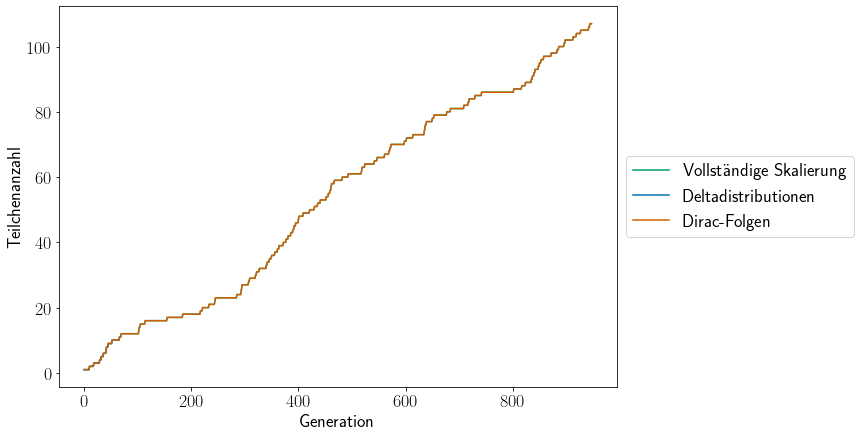

In [17]:
# Plot particles (excluding last event)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(values0[0], values0[2], c="g", label="Vollständige Skalierung")
ax.plot(values1[0], values1[2], c="b", label="Deltadistributionen")
ax.plot(values2[0], values2[2], c="r", label="Dirac-Folgen")
ax.set_xlabel("Generation")
ax.set_ylabel("Teilchenanzahl")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [18]:
from bisect import bisect

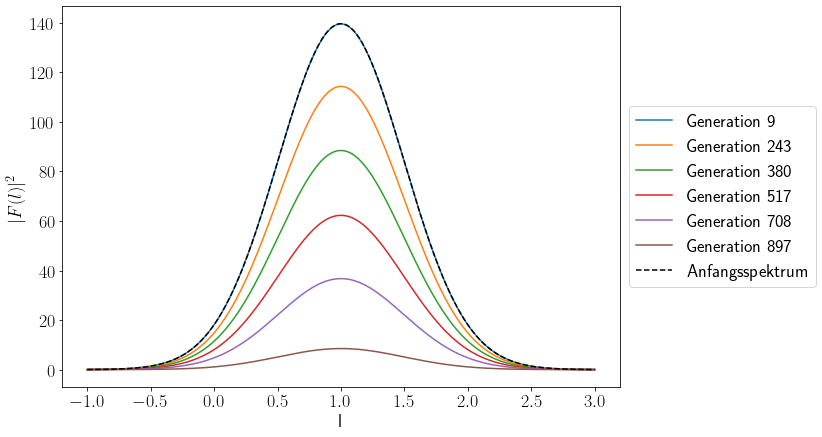

In [19]:
# Plot full scaling
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
x_i = np.arange(-1,3+0.001,0.001)

geni = 0         # to count the generations
gennontrivi = 0  # to count generations with l!=0
for i in res0.records[0:-1]:
    if len(i.incoming_particles) != len(i.outgoing_particles):
        if gennontrivi%20 == 0:
            ax.plot(x_i, i.out_field.spectrum(x_i), label=f'Generation {geni}')
        gennontrivi = gennontrivi + 1
    geni = geni + 1
ax.plot(x_i, res0.records[0].in_field.spectrum(x_i), '--', c='black', label='Anfangsspektrum')

ax.set_xlabel("l")
ax.set_ylabel(r"$|F(l)|^{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("scaling.pdf", bbox_inches='tight')
plt.show()

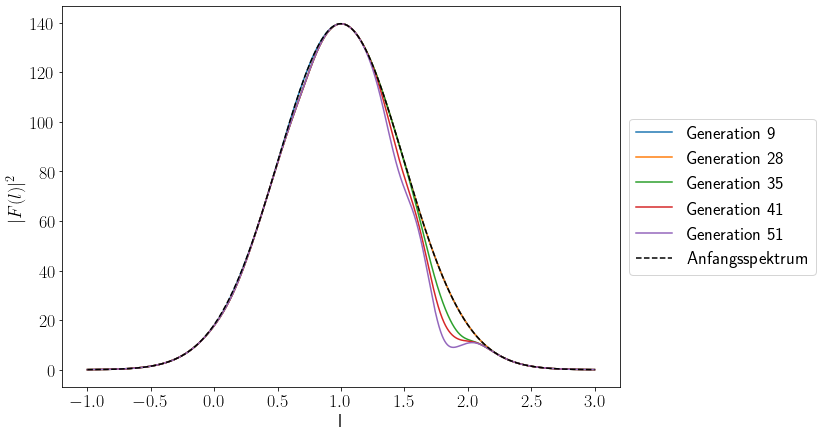

In [20]:
# plot dirac
def plot_dirac(result,name,skip=2,illegal=False,ylim=[]):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    x_i = np.arange(-1,3+0.001,0.001)

    geni = 0
    gennontrivi = 0
    for i in result.records[0:-1]:
        if len(i.incoming_particles) != len(i.outgoing_particles):
            if gennontrivi%skip == 0:
                ax.plot(x_i, i.out_field.spectrum(x_i), label=f'Generation {geni}')
            gennontrivi = gennontrivi + 1
        geni = geni + 1
    ax.plot(x_i, result.records[0].in_field.spectrum(x_i), '--', c='black', label=f'Anfangsspektrum')
    if illegal:
        ax.plot(x_i, result.records[-1].out_field.spectrum(x_i), '--', c='gray', label=f'Generation {geni}')

    ax.tick_params(axis='y', which='minor', bottom=False)
    ax.set_xlabel("l")
    ax.set_ylabel(r"$|F(l)|^{2}$")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if ylim != []:
        ax.set_ylim(ylim[0],ylim[1])

    file_path = f"{name}.pdf"
    plt.savefig(file_path, bbox_inches='tight')
    plt.show()

plot_dirac(result=res1,name="dirac")



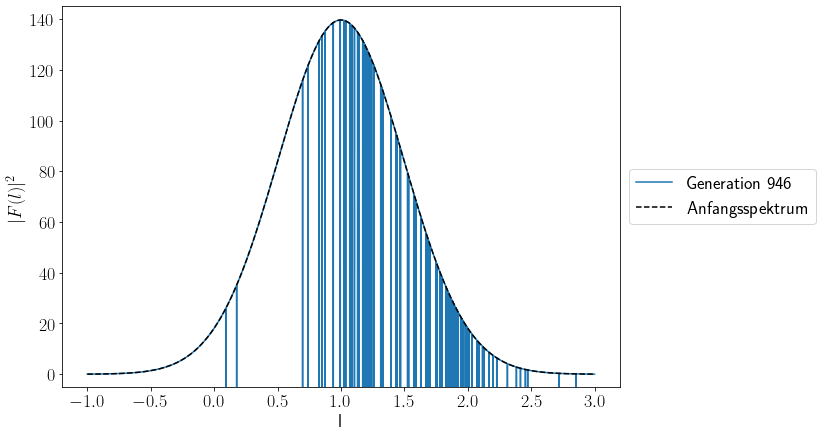

In [21]:
# Plot delta
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
x_i = np.arange(-1,3+0.001,0.001)
y_i = res2.records[-2].out_field.spectrum(x_i)

# Add the specific l and values where delta functions were subtracted so they are visible
for i in res2.records[-2].out_field.spectrum.l_array:
    index = bisect(x_i, i)
    x_i = np.insert(x_i, index, i)
    y_i = np.insert(y_i, index, res2.records[-2].out_field.spectrum(i))

ax.plot(x_i, y_i, label=f'Generation {len(res2.records)-2}')
# -1 because the last gen is not allowed, -1 because gen numbering starts at 0 => -2 in total
ax.plot(x_i, res2.records[0].in_field.spectrum(x_i), '--', c='black', label=f'Anfangsspektrum')
ax.set_ylim(-5,145)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xlabel("l")
ax.set_ylabel(r"$|F(l)|^{2}$")

plt.savefig("delta.pdf", bbox_inches='tight')
plt.show()

In [22]:
i = len(res0.records) - 1
if res0.records[-1].stop_flag:
    print(f'Generator stopped at generation {i} because field reached 0 (during that generation).')
else:
    print(f'Generator reached the last generation ({i}).')

Generator stopped at generation 947 because field reached 0 (during that generation).


In [23]:
print(f"Outgoing particles: (Including starting electron, excluding last event)\n Full scaling: {values0[2][-1]}\n Dirac:        {values1[2][-1]}\n Delta:        {values2[2][-1]}")

Outgoing particles: (Including starting electron, excluding last event)
 Full scaling: 107
 Dirac:        11
 Delta:        107


In [24]:
ratio0 = round( (100*(res0.records[-2].out_field.total_energy / res0.records[0].out_field.total_energy)), 2)
ratio1 = round( (100*(res1.records[-2].out_field.total_energy / res1.records[0].out_field.total_energy)), 2)
ratio2 = round( (100*(res2.records[-2].out_field.total_energy / res2.records[0].out_field.total_energy)), 2)

print(f'Remaining field energy compared to start:\n Full scaling: {ratio0}%\n Dirac:        {ratio1}%\n Delta:        {ratio2}%')

Remaining field energy compared to start:
 Full scaling: 0.98%
 Dirac:        92.57%
 Delta:        0.98%


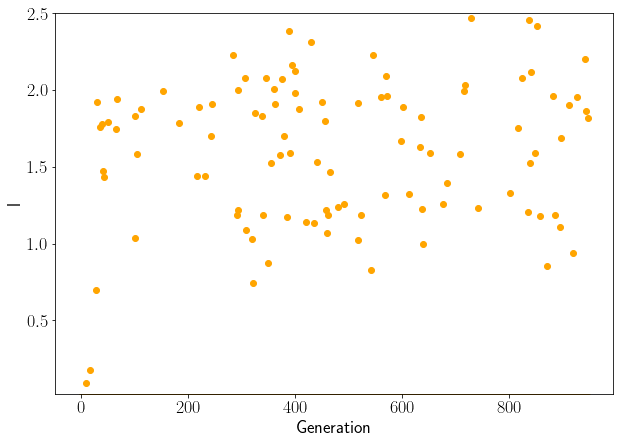

In [25]:
yi = get_en_frac_sum(res0)
xi = np.arange(0,len(yi))
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(xi,yi, c='orange')
ax.set_ylim(0.02,2.5)
ax.set_xlabel("Generation")
ax.set_ylabel("l")

plt.savefig("fractions.pdf", bbox_inches='tight')
plt.show()

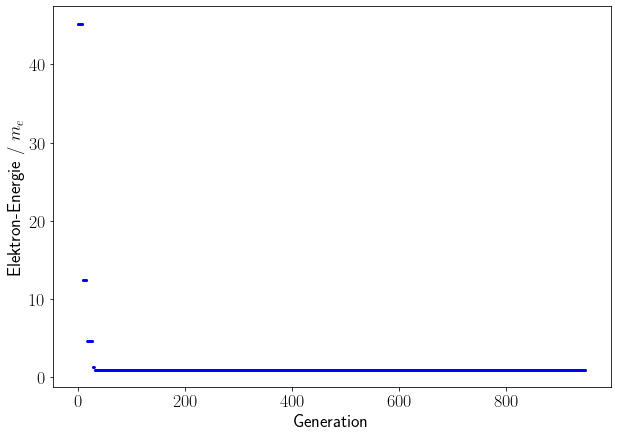

In [26]:
yi = elec_en[0]
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(xi,yi, c='blue', s=3)
ax.set_xlabel("Generation")
ax.set_ylabel(r"Elektron-Energie / $m_{e}$")

plt.savefig("electron_energy.pdf", bbox_inches='tight')
plt.show()

'Starting generator'

Found roots: [1.922499999999895, 2.207499999999889], stopping generator
Last event: 113
Runtime = 1.47 s


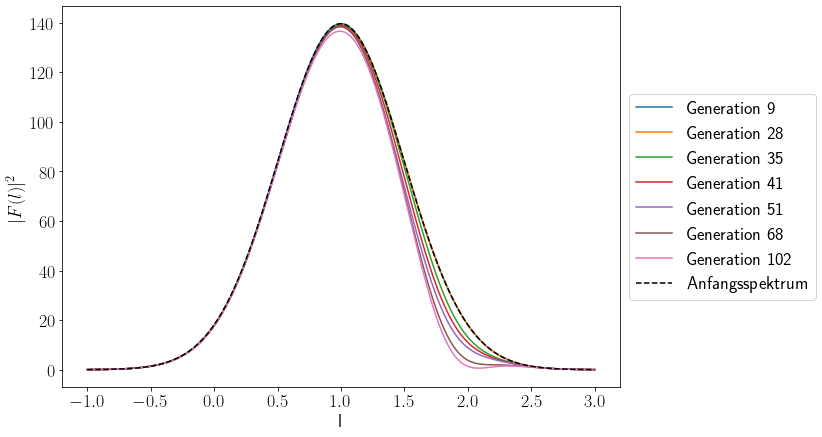

'Starting generator'

Found roots: [1.7827500000015974, 1.814250000001608], stopping generator
Last event: 65
Runtime = 4.114 s


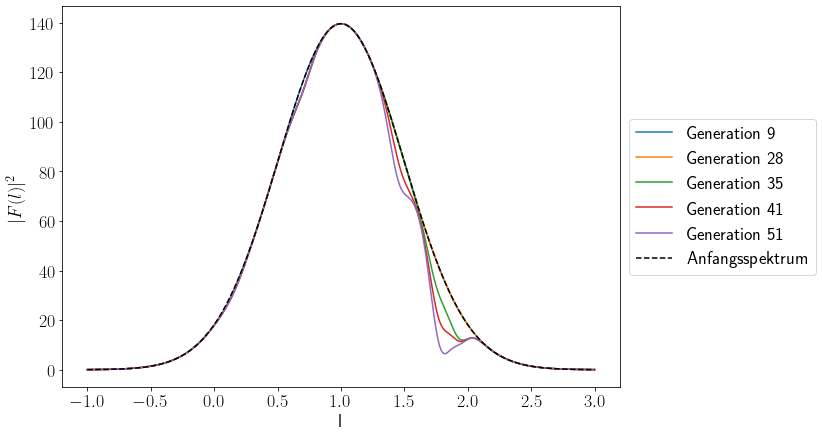

'Starting generator'

Found roots: [1.7682500000100627, 1.7800500000100872], stopping generator
Last event: 40
Runtime = 8.229 s


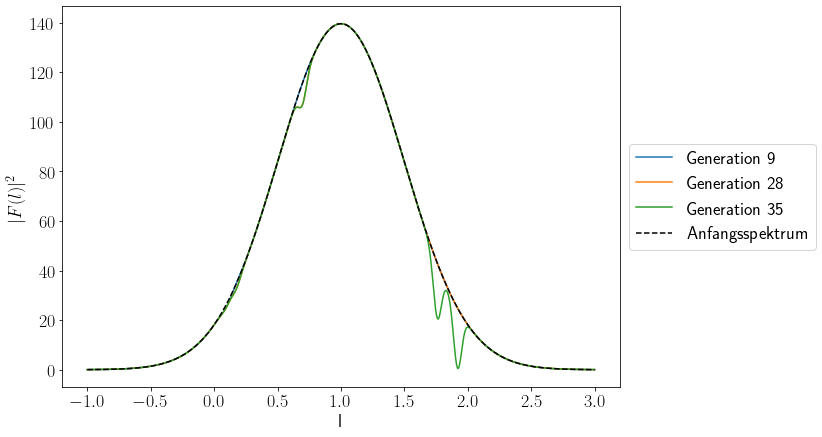

In [30]:
# Dirac series for different epsilon
res3 = run_cascade_generator(max_no_events=500,method=1, epsilon=0.05)
plot_dirac(result=res3,name="dirac_0.02")
res3 = run_cascade_generator(max_no_events=500,method=1, epsilon=0.005)
plot_dirac(result=res3,name="dirac_0.005")
res3 = run_cascade_generator(max_no_events=500,method=1, epsilon=0.001)
plot_dirac(result=res3,name="dirac_0.001")

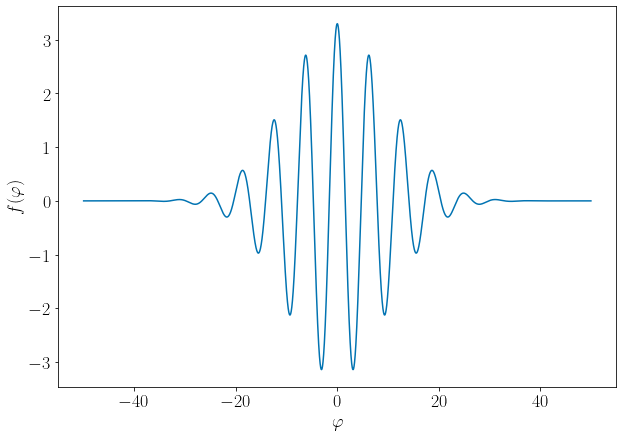

In [28]:
def ort_paket(phi, sigma_phi, real=False):
    const = 3.3
    f = const * np.exp(- (phi-0)**2 / (2*sigma_phi**2)) * np.exp(1j * phi)
    if real:
        return np.real(f)
    else:
        return np.abs(f)**2

x = np.arange(-50.0, 50.01, 0.01)
sigma = 10
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$f(\varphi)$')
ax.plot(x, ort_paket(x, sigma, real=True), '-', c='b')
plt.savefig("startpaket.pdf", bbox_inches='tight')
plt.show()

'Starting generator'

Found roots: [1.7664999999994753, 1.8544999999994656], stopping generator
Last event: 51
Runtime = 1.779 s


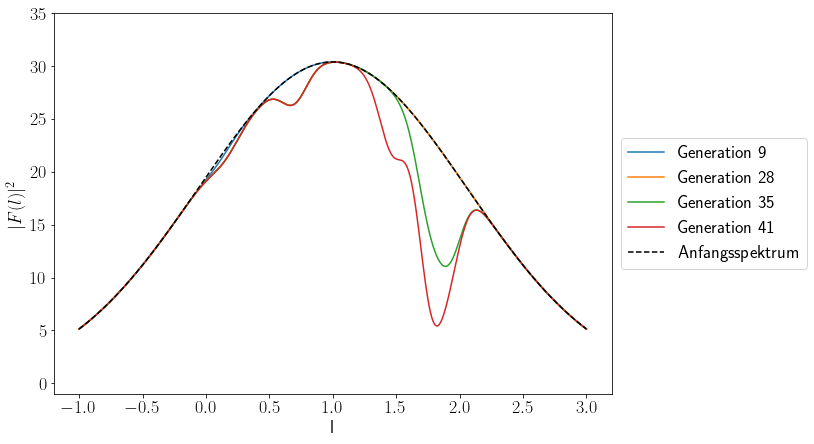

'Starting generator'

Found roots: [1.9524999999994543, 2.045499999999444], stopping generator
Last event: 31
Runtime = 0.517 s


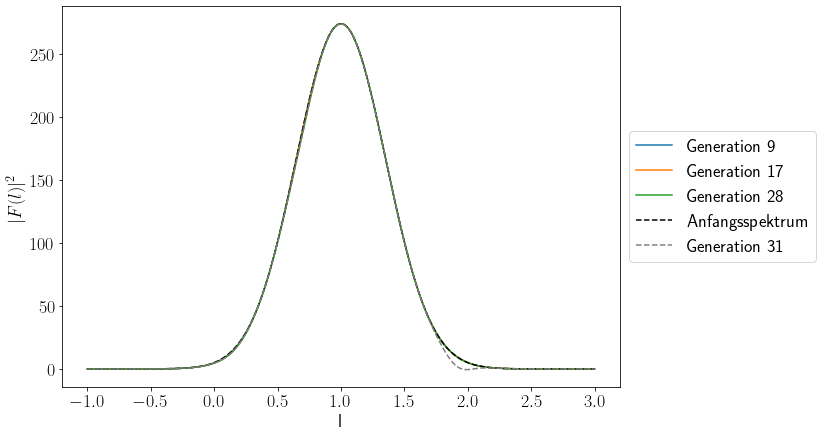

In [29]:
# Dirac series for different sigma_l
res4 = run_cascade_generator(max_no_events=500,method=1, sigma=1.5)
plot_dirac(result=res4,skip=2,name="sigma_1.5",ylim=[-1,35])
res4 = run_cascade_generator(max_no_events=500,method=1, sigma=0.5)
plot_dirac(result=res4,skip=1,name="sigma_0.5",illegal=True)